## TC 5033
### Word Embeddings

<br>

#### Activity 3b: Text Classification using RNNs and AG_NEWS dataset in PyTorch
<br>

### Team:
* Elmer Payro Costilla - A01014943
* Christopher Valdez Cantú - A01793549
* José Francisco Muñoz del Ángel - A01794174
* Luis José Navarrete Baduy - A017939192   

<br> 

- Objective:
    - Understand the basics of Recurrent Neural Networks (RNNs) and their application in text classification.
    - Learn how to handle a real-world text dataset, AG_NEWS, in PyTorch.
    - Gain hands-on experience in defining, training, and evaluating a text classification model in PyTorch.
    
<br>

- Instructions:
    - Data Preparation: Starter code will be provided that loads the AG_NEWS dataset and prepares it for training. Do not modify this part. However, you should be sure to understand it, and comment it, the use of markdown cells is suggested. 

    - Model Setup: A skeleton code for the RNN model class will be provided. Complete this class and use it to instantiate your model.

    - Implementing Accuracy Function: Write a function that takes model predictions and ground truth labels as input and returns the model's accuracy.

    - Training Function: Implement a function that performs training on the given model using the AG_NEWS dataset. Your model should achieve an accuracy of at least 80% to get full marks for this part.

    - Text Sampling: Write a function that takes a sample text as input and classifies it using your trained model.

    - Confusion Matrix: Implement a function to display the confusion matrix for your model on the test data.

    - Submission: Submit your completed Jupyter Notebook. Make sure to include a markdown cell at the beginning of the notebook that lists the names of all team members. Teams should consist of 3 to 4 members.
    
<br>

- Evaluation Criteria:

    - Correct setup of all the required libraries and modules (10%)
    - Code Quality (30%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity. Comments should be given for all the provided code, this will help you understand its functionality.
    
   - Functionality (60%): 
        - All the functions should execute without errors and provide the expected outputs.
        - RNN model class (20%)
        - Accuracy fucntion (10%)
        - Training function (10%)
        - Sampling function (10%)
        - Confucion matrix (10%)

        - The model should achieve at least an 80% accuracy on the AG_NEWS test set for full marks in this criterion.


Dataset

https://pytorch.org/text/stable/datasets.html#text-classification

https://paperswithcode.com/dataset/ag-news


### Import libraries

In [1]:
#%pip install torchtext
#%pip install torchdata
#%pip install scikit-plot
#%pip install portalocker
# conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch

In [2]:
# The following libraries are required for running the given code
# Please feel free to add any libraries you consider adecuate to complete the assingment.
import numpy as np
#PyTorch libraries
import torch
from torchtext.datasets import AG_NEWS
# Dataloader library
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
# Libraries to prepare the data
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
# neural layers
from torch import nn
from torch.nn import functional as F
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# These libraries are suggested to plot confusion matrix
# you may use others
import scikitplot as skplt
import gc

In [3]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Get the train and the test datasets and dataloaders

Classes:

* 1 - World

* 2 - Sports

* 3 - Business

* 4 - Sci/Tech

We will convert them to:

* 0 - World

* 1 - Sports

* 2 - Business

* 3 - Sci/Tech

## Data preparation

Data preparation is where we get our data ready for the model. We load the data, organize it, and make sure it's in the right format.


In [4]:
train_dataset, test_dataset = AG_NEWS()
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

In [5]:
# Get the tokeniser
# tokeniser object
tokeniser = get_tokenizer('basic_english')

def yield_tokens(data):
    for _, text in data:
        yield tokeniser(text)

In [6]:
# Build the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>"])
#set unknown token at position 0
vocab.set_default_index(vocab["<unk>"])

In [7]:
#test tokens
tokens = tokeniser('Welcome to TE3007')
print(tokens, vocab(tokens))

['welcome', 'to', 'te3007'] [3314, 4, 0]


In [8]:
NUM_TRAIN = int(len(train_dataset)*0.9)
NUM_VAL = len(train_dataset) - NUM_TRAIN

In [9]:
train_dataset, val_dataset = random_split(train_dataset, [NUM_TRAIN, NUM_VAL])

In [10]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

108000 12000 7600


In [11]:
max_tokens = 50
# function passed to the DataLoader to process a batch of data as indicated
def collate_batch(batch):
    # Get label and text
    y, x = list(zip(*batch))
    
    # Create list with indices from tokeniser
    x = [vocab(tokeniser(text)) for text in x]
    x = [t + ([0]*(max_tokens - len(t))) if len(t) < max_tokens else t[:max_tokens] for t in x]

    # Prepare the labels, by subtracting 1 to get them in the range 0-3
    return torch.tensor(x, dtype=torch.int32), torch.tensor(y) - 1

In [12]:
labels =  ["World", "Sports", "Business", "Sci/Tech"]
BATCH_SIZE = 256

In [13]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)

### Let us build our RNN model

This section is about building our text classification model. We'll lay out its structure and how it should work.


In [14]:
EMBEDDING_SIZE = 50
NEURONS = 40
LAYERS = 4
NUM_CLASSES = 4

In [15]:
class RNN_Model_1(nn.Module):
    def __init__(self, embed_size, hidden, layers, num_classes):
        super().__init__()
        # First layer must have a size of lenght vocabulary
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_size)
        # You may use PyTorch nn.GRU(), nn.RNN(), or nn.LSTM()
        self.rnn = nn.RNN(input_size=embed_size, hidden_size=hidden, num_layers=layers, batch_first=True)                        
        # output layer must have input as hidden layers and output the number of classes
        self.linear = nn.Linear(hidden, num_classes)        
        
    def forward(self, x):
        # implement forward pass. This function will be called when executing the model
        embeddings = self.embedding_layer(x)
        output, hidden = self.rnn(embeddings, torch.randn(LAYERS, len(x), NEURONS))
        return self.linear(output[:,-1])
        

* Long Short-Term Memory (LSTM) networks are an improvement over simple Recurrent Neural Networks (RNNs). LSTMs are designed to avoid the vanishing gradient problem, which is common in standard RNNs, especially with longer sequences.
* With their structure of memory cells and control gates (forget, input, and output gates), LSTMs can maintain relevant information over long sequences of data, making them more suitable for natural language processing tasks where dependencies between words can span across long sequences.
* Initializing the hidden and cell states to zero for each batch is a common practice, as it provides a consistent starting point for learning each sequence. This is particularly useful in the context of text classification, where each input is generally independent of the others

In [16]:
class RNN_Model_1(nn.Module):
    def __init__(self, embed_size, hidden, layers, num_classes):
        super(RNN_Model_1, self).__init__()
        self.layers = layers
        self.hidden = hidden
        # Embedding layer
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_size)
        # LSTM instead of RNN
        self.lstm = nn.LSTM(input_size=embed_size, hidden_size=hidden, num_layers=layers, batch_first=True)                        
        # Linear layer for classification
        self.linear = nn.Linear(hidden, num_classes)     

    def forward(self, x):
        # Embedding the input
        embeddings = self.embedding_layer(x)
        # Hidden and cell state initialized to zeros
        h0 = torch.zeros(self.layers, x.size(0), self.hidden).to(x.device)
        c0 = torch.zeros(self.layers, x.size(0), self.hidden).to(x.device)
        # Passing through LSTM
        output, (hn, cn) = self.lstm(embeddings, (h0, c0))
        # Taking the last output of the sequence for classification
        return self.linear(output[:, -1])


In [17]:
from sklearn.metrics import accuracy_score

def accuracy(model, loss_fn, loader):
    with torch.no_grad():
        Ys, Y_preds, losses = [], [], []
        for X, Y in loader:
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())
            
            Ys.append(Y)
            Y_preds.append(preds.argmax(dim=-1))
        
        Ys = torch.cat(Ys)
        Y_preds = torch.cat(Y_preds)

        print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))
        print("Valid Acc  : {:.3f}".format(accuracy_score(Ys.detach().numpy(), Y_preds.detach().numpy())))

        

In [18]:
from tqdm import tqdm

def train(model, loss_fn, optimizer, epochs=10):
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader):
            Y_preds = model(X)            
            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
        accuracy(model,loss_fn, val_loader)

In [19]:
epochs = 15
lr = 1e-3
# instantiate model
loss_fn = nn.CrossEntropyLoss()
rnn_model = RNN_Model_1(EMBEDDING_SIZE, NEURONS, LAYERS, NUM_CLASSES)
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=lr)


## Training and Evaluation

### Training Function
This section includes the function to train the model using the AG_NEWS dataset. The function takes the model, optimizer, criterion, and data loaders as inputs and performs the training loop.

### Evaluation Metrics
After training, we evaluate the model's performance on the test set. We'll calculate accuracy and display a confusion matrix to understand the model's strengths and weaknesses in classifying news articles.


In [20]:
train(rnn_model, loss_fn=loss_fn, optimizer=optimizer,  epochs=epochs)

100%|██████████| 422/422 [00:35<00:00, 12.06it/s]


Train Loss : 1.032
Valid Loss : 0.729
Valid Acc  : 0.709


100%|██████████| 422/422 [00:34<00:00, 12.09it/s]


Train Loss : 0.526
Valid Loss : 0.437
Valid Acc  : 0.848


100%|██████████| 422/422 [00:35<00:00, 11.86it/s]


Train Loss : 0.361
Valid Loss : 0.373
Valid Acc  : 0.872


100%|██████████| 422/422 [00:36<00:00, 11.66it/s]


Train Loss : 0.294
Valid Loss : 0.346
Valid Acc  : 0.886


100%|██████████| 422/422 [00:34<00:00, 12.30it/s]


Train Loss : 0.249
Valid Loss : 0.328
Valid Acc  : 0.892


100%|██████████| 422/422 [00:34<00:00, 12.40it/s]


Train Loss : 0.216
Valid Loss : 0.348
Valid Acc  : 0.891


100%|██████████| 422/422 [00:34<00:00, 12.41it/s]


Train Loss : 0.188
Valid Loss : 0.341
Valid Acc  : 0.893


100%|██████████| 422/422 [00:34<00:00, 12.36it/s]


Train Loss : 0.166
Valid Loss : 0.338
Valid Acc  : 0.895


100%|██████████| 422/422 [00:34<00:00, 12.38it/s]


Train Loss : 0.148
Valid Loss : 0.351
Valid Acc  : 0.896


100%|██████████| 422/422 [00:34<00:00, 12.37it/s]


Train Loss : 0.133
Valid Loss : 0.368
Valid Acc  : 0.893


100%|██████████| 422/422 [00:34<00:00, 12.35it/s]


Train Loss : 0.119
Valid Loss : 0.388
Valid Acc  : 0.891


100%|██████████| 422/422 [00:34<00:00, 12.30it/s]


Train Loss : 0.109
Valid Loss : 0.391
Valid Acc  : 0.892


100%|██████████| 422/422 [00:34<00:00, 12.29it/s]


Train Loss : 0.099
Valid Loss : 0.403
Valid Acc  : 0.892


100%|██████████| 422/422 [00:34<00:00, 12.32it/s]


Train Loss : 0.090
Valid Loss : 0.412
Valid Acc  : 0.891


100%|██████████| 422/422 [00:34<00:00, 12.30it/s]


Train Loss : 0.083
Valid Loss : 0.427
Valid Acc  : 0.891


In [21]:
print(accuracy(rnn_model, loss_fn, test_loader))

Valid Loss : 0.441
Valid Acc  : 0.895
None


## Text Sampling with the Model

We take some sample texts, use the model to predict their categories, and then see how well it did.

### Steps:
1. **Preparing the Model**: We start by setting our model to 'evaluation mode'. This makes sure it behaves correctly, not like when it's learning.
   
2. **Choosing Samples**: We pick a few texts from our data to test the model.

3. **Making Predictions**: The model looks at each text and guesses its category.

4. **Showing Results**:  We then display these texts along with the model's guesses and the actual categories. This helps us see if the model is doing a good job.


In [22]:
def index_to_token(vocab, index):
    for token, idx in vocab.get_stoi().items():
        if idx == index:
            return token
    return "<unk>"  # Return unknown token if not found

In [23]:
def sample_text(model, loader):
    model.eval()  # Set the model to evaluation mode
    samples = []  # List to store text and predicted labels

    with torch.no_grad():  # Disable gradient computation
        # Get one batch of data for sampling
        texts, labels = next(iter(loader))

        outputs = model(texts)  # Get model predictions
        _, predicted = torch.max(outputs, 1)  # Convert outputs to predicted class labels

        # Store sample text and predictions in the list
        for i in range(len(texts)):
            # Convert indices back to text
            sample_text = " ".join([index_to_token(vocab, idx) for idx in texts[i] if idx != vocab['<unk>']])
            samples.append((sample_text, labels[i].item(), predicted[i].item()))

    return samples



In [24]:
def display_samples(samples,n):
    # Print the first 10 items
    for i in range(min(n, len(samples))):  # Ensure not to exceed the list length
        sample_text, true_label, pred_label = samples[i]
        print(f"Sample Text: {sample_text}\nPredicted Label: {true_label} (True Label), {pred_label} (Predicted Label)\n")


In [25]:
samples = sample_text(rnn_model, test_loader)

In [26]:
display_samples(samples,5)

Sample Text: 14 palestinian militants killed in gaza gaza city , gaza strip sept . 7 , 2004 - israeli helicopters attacked a hamas training camp early tuesday , killing at least 14 militants and wounding 30 others in one of the deadliest airstrikes since fighting broke out four years ago .
Predicted Label: 0 (True Label), 0 (Predicted Label)

Sample Text: cards all hearts ten outs away from winter , knowing a ride was about to hit the runway way too soon . ten outs away from winter , and the st .
Predicted Label: 1 (True Label), 3 (Predicted Label)

Sample Text: viacom may pay sirius \$ howard howard stern hinted broadly yesterday that he might continue his involvement with viacom after he switches to satellite radio in 15 months .
Predicted Label: 2 (True Label), 2 (Predicted Label)

Sample Text: salesforce . com launches on-demand support system on-demand crm provider salesforce . com wednesday rolled out a parallel service its calling support . com and aiming at corporations with fa

## Confusion Matrix

In this section, we delve into evaluating the accuracy of our model using a confusion matrix. This process begins by having the model predict categories for a collection of texts, where we record both the model's predictions and the actual, correct categories. These predictions are then used to construct a confusion matrix. This matrix is presented as a heatmap, making it easy to identify patterns and anomalies in the model's performance. 


In [27]:
def get_predictions(model, loader):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for X, Y in loader:
            preds = model(X)
            _, predicted = torch.max(preds, 1)
            true_labels.extend(Y.tolist())
            predicted_labels.extend(predicted.tolist())

    return true_labels, predicted_labels

In [28]:
def plot_confusion_matrix(true_labels, predicted_labels, classes):
    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    
    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

In [29]:
# Get predictions
true_labels, predicted_labels = get_predictions(rnn_model, test_loader)

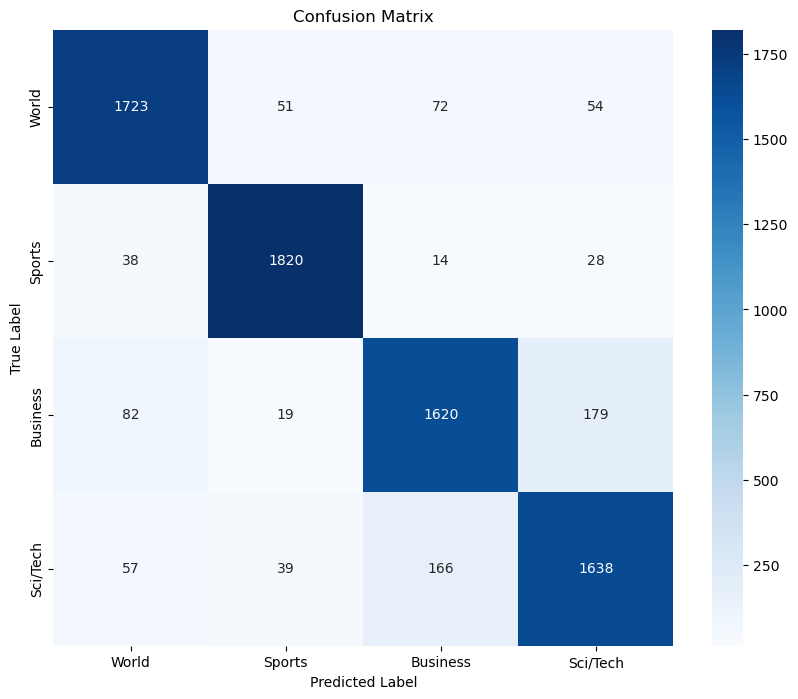

In [30]:
# Plot confusion matrix
plot_confusion_matrix(true_labels, predicted_labels, labels)
